In [1]:
# import necessary packages
import pandas as pd 
import numpy as np 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics import tsaplots
import base64
from IPython.display import HTML

# import data
df = pd.read_csv('teleco_time_series .csv')

# Explore data for outliers, nulls, and inconcistencies 
display(df.shape)
display(df.info())
display(df.describe())
display(df.head())

(731, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


None

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


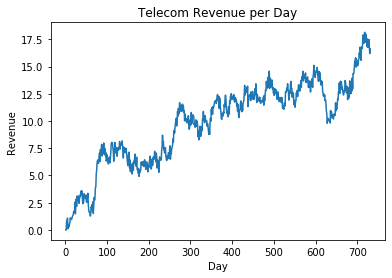

In [2]:
#Visually check for trends to determine the need for tranformation to static

e = np.array(df['Day'])
i = np.array(df['Revenue'])

plt.plot(e,i)
plt.title('Telecom Revenue per Day')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.show;

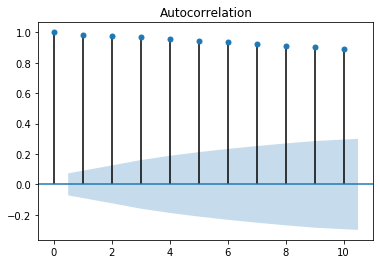

In [3]:
# plot autocorrelation function
fig = tsaplots.plot_acf(i, lags=10)
plt.show()

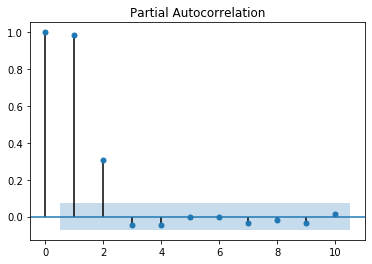

In [4]:
# plot partial autocorrelation funciton
fig = tsaplots.plot_pacf(i, lags=10)
plt.show()

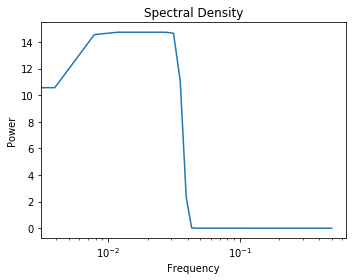

In [5]:
# Power Spectral Density
np.random.seed(0)
time_step = .01
time = np.arange(0, 70, time_step)
s = np.sin(0.5 * np.pi * time * (1 + .1 * time))
f, p = signal.welch(s)
plt.figure(figsize=(5, 4))
plt.semilogx(f, p)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout();

##### There are definitely trends in the data, an ad fuller test will be used to further explore the data.

In [6]:
# Run the adfuller test to futher explore statistical trends in the data
test = adfuller(df['Revenue'])
test

(-1.9246121573101853,
 0.3205728150793957,
 1,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 965.0609576707513)

##### The statistic in position 0 provides liklihood of stationary (the more negative the more stationary). The first element, .32, says that we should reject the null hypothesis and reject non-stationary. Due to the inadequate test statistic, the data will be transformed in order to avoid overfitting of our model.

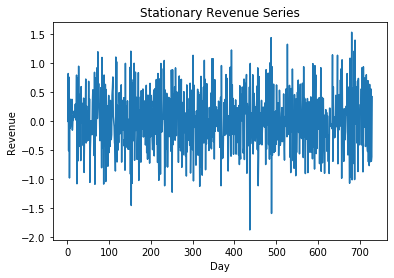

In [7]:
# Make the data stationary using difference of squares method
stationary = df.Revenue.diff().dropna()

plt.plot(stationary)
plt.title('Stationary Revenue Series')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.show()

In [8]:
# evaluate the now stationary data for adequacy
test2 = adfuller(stationary)
test2

(-44.874527193876,
 0.0,
 0,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 965.5032159185916)

##### The test statistic and p-value have now indicated that one transformation using the difference of squares method is all that is necessary to avoid overfitting. Our order will then be: p=2, q=1, d=1.

Test RMSE: 0.496


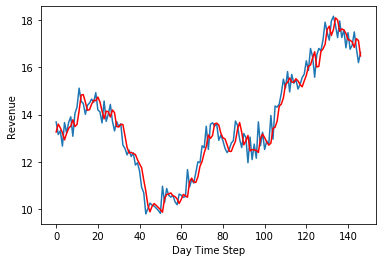

In [9]:
X = df.Revenue.values
# take a sampling of 20%
size = int(len(X)*.8)
train, test = X[0:size], X[size: len(X)]
timeseries = [x for x in train]
predictions = list()

#Use a loop to create a model with predictions for each entry to evaluate model accuracy using the root mean squared error test.
for i in range(len(test)):
    model= ARIMA(timeseries, order=(2,1,2))
    model_fit = model.fit()
    out = model_fit.forecast()
    upper = out[0]
    predictions.append(upper)
    observations = test[i]
    timeseries.append(observations)

rmse = sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.xlabel('Day Time Step')
pyplot.ylabel('Revenue')
pyplot.show();

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -488.832
Date:                Fri, 19 Feb 2021   AIC                            987.663
Time:                        16:50:22   BIC                           1010.622
Sample:                             0   HQIC                           996.521
                                - 730                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3066      0.285      1.074      0.283      -0.253       0.866
ar.L2          0.3150      0.178      1.772      0.076      -0.033       0.663
ma.L1         -0.7705      0.289     -2.668      0.008      -1.336      -0.205
ma.L2          0.0697      0.088      0.795      0.426      -0.102       0.241
sigma2         0.2238      0.013     17.535      0.000       0.199       0.249
===================================================================================
Ljung-Box (Q):                       36.02   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.65   Prob(JB):                         0.32
Heteroskedasticity (H):               1.02   Skew:                            -0.04
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

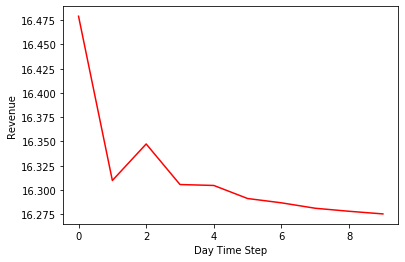

In [11]:
forecasting = model_fit.get_forecast(steps=10).predicted_mean


pyplot.plot(forecasting, color='red')
pyplot.xlabel('Day Time Step')
pyplot.ylabel('Revenue')
pyplot.show();

In [12]:
stationary.to_csv('fully_prepared_data.csv', sep=',')
def create_download_link(stationary, title = "Download CSV file", filename = "fully_prepared_data.csv"):
    csv = stationary.to_csv(index = False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(stationary)